In [170]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import requests

**CONSTANTS**

In [171]:
RESIDENCE_TARGET_RATIO = 1.676009385
AMENITIES_TARGET_RATIO = 0.18315354

first_year = 1980
curr_year = 2023
last_year = 2040

**DATA INPUT**

In [172]:
# API CALL TO SPREADSHEETS #
api_key = 'YOUR_API_KEY'
spreadsheet_id = 'YOUR_SPREADSHEET_ID'
sheet_name = 'YOUR_SHEET_NAME'
sheet_range = 'YOUR_SHEET_RANGE'

# Define the range or endpoint you want to access
endpoint = f'https://sheets.googleapis.com/v4/spreadsheets/{spreadsheet_id}/values/{sheet_name}!{sheet_range}'

# Include the API key as a query parameter
params = {'key': api_key}

spreadsheet = np.array(requests.get(endpoint, params=params).json()['values']).astype(float)

**PRE-PROCESSING**

1. Assign axes: data and labels

In [173]:
office_ref = spreadsheet[0][curr_year-first_year]

office_demand = []
residential_early_demand = []
residential_mid_demand = []
residential_essential_demand = []
residential_executive_demand = []
residential_senior_demand = []
amenities_demand = []

for i in range(last_year-first_year+1):
    office = spreadsheet[0][i]
    office_demand.append(office / office_ref)

    targetResidentialToOffice = office * RESIDENCE_TARGET_RATIO
    fulfilled = spreadsheet[1][i] / targetResidentialToOffice

    residential_early_demand.append(fulfilled * spreadsheet[2][i])
    residential_mid_demand.append(fulfilled * spreadsheet[3][i])
    residential_essential_demand.append(fulfilled * spreadsheet[4][i])
    residential_executive_demand.append(fulfilled * spreadsheet[5][i])
    residential_senior_demand.append(fulfilled * spreadsheet[6][i])

amenities_demand = spreadsheet[8]

In [174]:
raw_data = np.vstack((office_demand, residential_early_demand, residential_mid_demand, residential_essential_demand,
                      residential_executive_demand, residential_senior_demand, amenities_demand))   # (datalist1, datalist2, ...)
labels = ["Office/Lab", "Housing Young Professionals", "Housing Workforce", "Housing Families", "Housing Professionals",
          "Housing Seniors", "Amenities"]     # [label1, label2, ...]

2. Interpolate data to smooth out the animation
    
    
* ``smooth_rate = 0``  -> no smoothed plot
* ``smooth_rate = 10`` -> smoothed plot (10 values between each value)

In [175]:
smooth_rate = 3

data = []
for row_csv in raw_data:
    num_points = smooth_rate + 1
    max_val = 1
    row_csv[row_csv>max_val] = max_val
    smoothed_row = []
    for i in range(len(row_csv)):
        init_val = row_csv[i]
        end_val = row_csv[i+1] if i+1 < len(row_csv) else row_csv[i]
        smoothed_row.extend(np.linspace(init_val, end_val, num_points))
    data.append(100*np.asarray(smoothed_row, dtype='float'))

``(function) def curve_plot(values: array, curve_rate: int) -> angles: array, values: array``

Curves the plotted values between each axis.
* ``curve_rate = 0``    -> no curved plot
* ``curve_rate = 10``   -> curved plot (10 dots between each axis)

In [176]:
curve_rate = 10

def curve_plot(values, curve_rate):
    num_points = curve_rate + 1
    angles = np.linspace(0, 2 * np.pi, num_points*(len(labels)-1))
    #values = [np.linspace(values[i], values[i+1], num_points) for i in range(len(values)-1)]
    curve_values = []
    for i in range(len(values)-1):
        curve_values.extend(np.linspace(values[i], values[i+1], num_points))
    return angles, curve_values

**RADAR PLOT CREATION**

In [177]:
# Radar plot setup
data.append(data[0])
labels.append(labels[0])

Text(0.7853981633974483, 15, '1980')

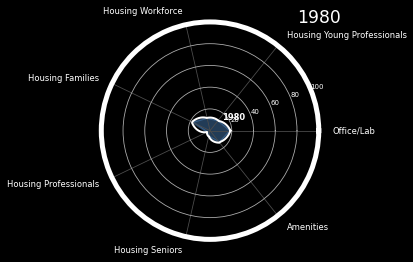

In [178]:
# Coordinates setup
angles = np.linspace(0, 2 * np.pi, len(labels))
values = [d[0] for d in data]

# Plot setup
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})  # adjust radarplot size adding as argument ``figsize = (15,15)``
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.xaxis.grid(True, which='both', color='0.3')
ax.spines['polar'].set(linewidth=5, color='white', zorder=100)
ax.set_rlim(0, 100)

# Label setup
ax.tick_params(axis='x', labelsize='small', colors='white')  # For angle labels
ax.tick_params(axis='y', labelsize='x-small', colors='white')  # For value labels
ax.set_xticks(angles[:-1], labels[:-1], color='white')

for label, angle in zip(ax.get_xticklabels(), angles[:-1]):
    if angle == np.pi/2 or angle == 3*np.pi/2:
        label.set_horizontalalignment('center')
    elif np.pi/2 < angle < 3*np.pi/2:
        label.set_horizontalalignment('right')
    else:
        label.set_horizontalalignment('left')

# Line setup
radar_line, = ax.fill(angles, values, facecolor='#5797DB', edgecolor='#5797DB', linewidth=2, alpha=0.4, zorder=0)

if curve_rate > 0:
    angles, values = curve_plot(values, curve_rate)

line, = ax.plot(angles, values, color='white', linestyle='-', linewidth=2, zorder=8)

# Year setup
# year_text is the year counter on top right corner
year_text = plt.text(0.90, 1, first_year, color='white', fontsize='xx-large', transform=plt.gca().transAxes)
plt.text(np.pi/4, 15, first_year, color='white', fontsize='small', fontweight='bold', zorder=100)

``(function) def update_plot(angles: array, data: array) -> radar_line: array``

Updates the plot with the next values in the dataset.
* ``i`` : counter of calls to *update_plot*

In [179]:
def update_plot(i, angles, data):
    global radar_line, fill, curve_rate
    
    year = first_year+int(i/(smooth_rate+1))

    values = [d[i] for d in data]
    if curve_rate > 0:
        angles, values = curve_plot(values, curve_rate)
    
    if year <= last_year: year_text.set_text(year)
    if year == curr_year+1: year_text.set_color('yellow')
    if year == last_year:
        line, = ax.plot(angles, values, color='#157F1F', linestyle='-', linewidth=5, zorder=8)
        return radar_line
    
    radar_line.set_xy(np.array([angles, values]).T)

    # Create plots for the data lines
    if year == curr_year and i%(smooth_rate+1) == 0:
        line, = ax.plot(angles, values, color='white', linestyle='-', linewidth=2, zorder=8)
        plt.text(np.pi / 16, 25, year, color='white', fontsize='small', fontweight='bold', zorder=100)
    elif year in [2025, 2028, 2031, 2034, 2037] and i%(smooth_rate+1) == smooth_rate:
        line, = ax.plot(angles, values, color='#d9db57', linestyle='-', linewidth=1, zorder=8)
        match year:
            case 2025: plt.text(2*np.pi - np.pi / 8, 20, year, color='#d9db57', fontsize='small', fontweight='bold', zorder=100)
            case 2028: plt.text(6* 2*np.pi / 7, 25, year, color='#d9db57', fontsize='small', fontweight='bold', zorder=100)
            case 2031: plt.text(6* 2*np.pi / 7, 45, year, color='#d9db57', fontsize='small', fontweight='bold', zorder=100)
            case 2034: plt.text(6* 2*np.pi / 7, 70, year, color='#d9db57', fontsize='small', fontweight='bold', zorder=100)
            case 2037: plt.text(6* 2*np.pi - np.pi / 6, 90, year, color='#d9db57', fontsize='small', fontweight='bold', zorder=100)

    return radar_line


**SAVE ANIMATION**

``interval = 10`` : 10ms delay between frames. A higher value means slower animation.

In [180]:
ani = FuncAnimation(fig, update_plot, frames=len(data[0]), fargs=(angles, data), interval=10)

# ani.save("animation.mp4", dpi=300)

# FFwriter = FFMpegWriter(fps=60)
# ani.save(f"animation.mp4", writer=FFwriter)

ani.save(f"curved_radarplot.gif", writer='pillow')

IndexError: list index out of range